# 10a: Introduction to Rasterio for working with raster data

This exercise introduces [ratsterio](https://rasterio.readthedocs.io/en/stable/) for working with [GIS raster datasets](https://docs.qgis.org/3.4/en/docs/gentle_gis_introduction/raster_data.html). 

We will use the `rasterio` library, along with `numpy` and `matplotlib` to open, explore, and create raster datasets.


In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import pathlib as pl

In [2]:
data_path = pl.Path("data/rasterio")  # set path to raster data folder

## Opening and closing raster datasets using `rasterio`
We can open a GeoTIFF file containing a digital elevation model of Mt. Rainier (20150818_rainier_summer-tile-30.tif) using `rasterio.open`, in a way that's similar to using Python’s built-in `open` function for text files.

In [3]:
raster_file = data_path / '20150818_rainier_summer-tile-30.tif'  # example raster data

In [4]:
dataset = rasterio.open(raster_file)

This returns a rasterio `DatasetReader` object (in this case called "dataset"). This object provides methods and attributes for accessing raster properties. Let's explore some of these properties. 

In [5]:
dataset.name  #  file name

'data/rasterio/20150818_rainier_summer-tile-30.tif'

In [6]:
dataset.driver  # The file format (`GTiff` is recommended)

'GTiff'

In [7]:
dataset.mode  # Opening mode - 'r' for read mode by default

'r'

In [8]:
dataset.count  # number of datasets or "bands" contained in the raster dataset

1

In [9]:
dataset.dtypes  # The raster data type, one of `numpy` types supported by the driver

('float32',)

In [10]:
dataset.width  # number of columns

827

In [11]:
dataset.height  # number of rows

761

In [12]:
dataset.nodata  # The value which represents “No Data”, if any

0.0

In [13]:
dataset.crs  # The coordinate reference system EPSG code

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [14]:
dataset.transform  # the transform matrix

Affine(30.0, 0.0, 583464.253406,
       0.0, -30.0, 5202549.0989)

More on the `transform` later...

Most of this information is contained within the dataset's metadata dictionary and can be accessed at once.

In [15]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 827,
 'height': 761,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'),
 'transform': Affine(30.0, 0.0, 583464.253406,
        0.0, -30.0, 5202549.0989)}

## Plotting

rasterio reads raster data into numpy arrays so plotting a single band as two dimensional data can be accomplished directly with `matplotlib.pyplot.imshow()`.

In [16]:
array = dataset.read(1)
type(array)

numpy.ndarray

using `plt.imshow()`, we can visualize the array data contained in the raster dataset

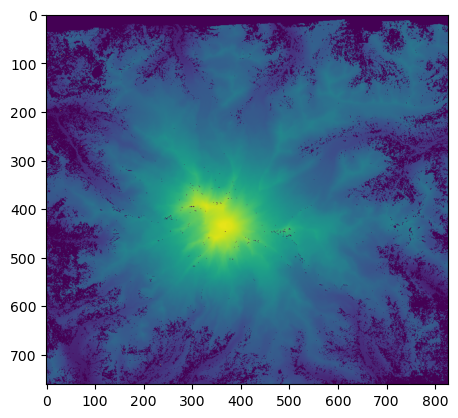

In [17]:
plt.imshow(array, vmin=500, vmax=4500);

rasterio also offers `rasterio.plot.show()` to display rasters images and label the axes with geo-referenced extents. It also masks "nodata" cells.

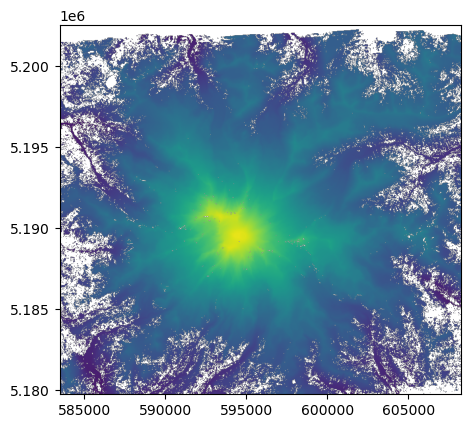

In [18]:
show(dataset, vmin=500, vmax=4500);

To plot a raster and a vector layers together, we need to initialize a plot object with `plt.subplots`, and pass the same ax argument to both plots. For example, let’s import the HUC12 polygon of the upper White River (see the GeoPandas notebooks for more information on working with geospatial vector data):

In [19]:
import geopandas as gpd
white_riv_huc12 = gpd.read_file('data/rasterio/white_river_huc12.shp')

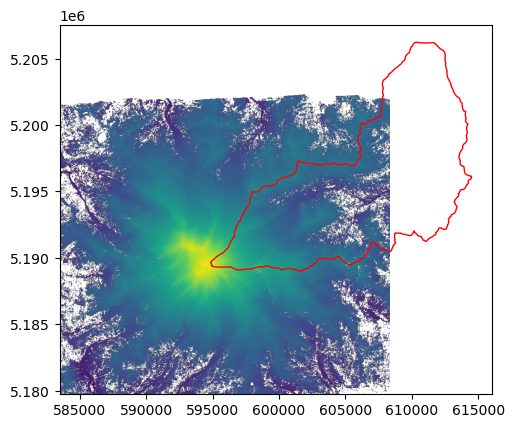

In [20]:
fig, ax = plt.subplots()
show(dataset, ax=ax, vmin=500, vmax=4500)
white_riv_huc12.plot(ax=ax, edgecolor='red', facecolor='None');

### Close the dataset when we're done

the `close()` method is used to close a dataset, releasing the underlying file handle and any associated resources. This is important for proper resource management, especially when dealing with many files or in long-running processes.

In [21]:
dataset.closed

False

In [22]:
dataset.close()

In [23]:
dataset.closed

True

## Accessing and manipulating raster data

It is best practice to use `rasterio.open()` within a `with` statement. This ensures proper closing of the dataset and resource management, even if errors occur. You might recognize this syntax from working with files in notebook `04_files_and_strings.ipynb`

In [24]:
with rasterio.open(data_path / '20150818_rainier_summer-tile-30.tif') as dataset:
    array_m = dataset.read(1)

In [25]:
type(array_m)

numpy.ndarray

### Convert to units of feet

In [26]:
array_ft = array_m * 3.2084

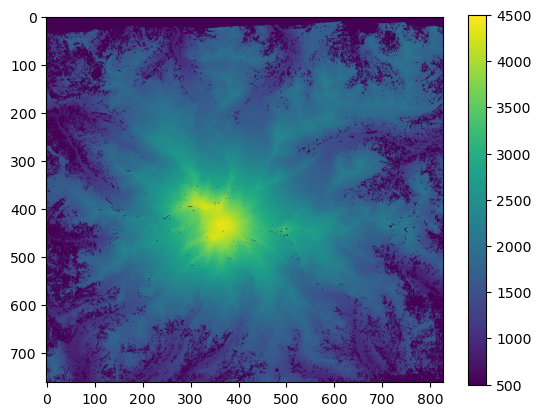

In [27]:
plt.imshow(array_m,  vmin=500, vmax=4500)
plt.colorbar();

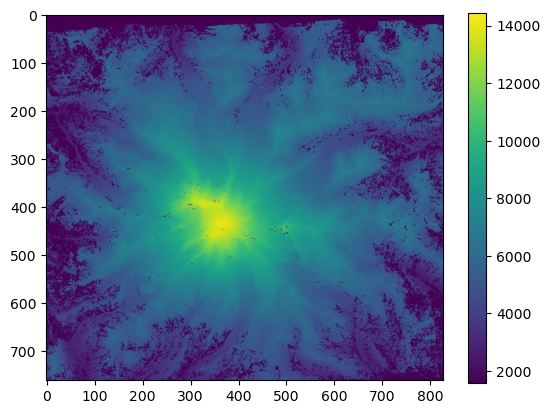

In [28]:
plt.imshow(array_ft,  vmin=1600, vmax=14450)
plt.colorbar();

### Make the data categorical
Bin the array data into three categories (1, 2, or 3) based on elevation values using numpy indexing

In [29]:
array_classified = array_ft.copy()

array_classified[array_classified < 6000] = 1                                 # Low elevation zone, less than 6,000 ft
array_classified[(array_classified < 10000) & (array_classified > 6000)] = 2  # Mid elevation zone, between 6,000 and 10,000 ft
array_classified[array_classified >= 10000] = 3                               # High elevation zone, greater than 10,000 ft

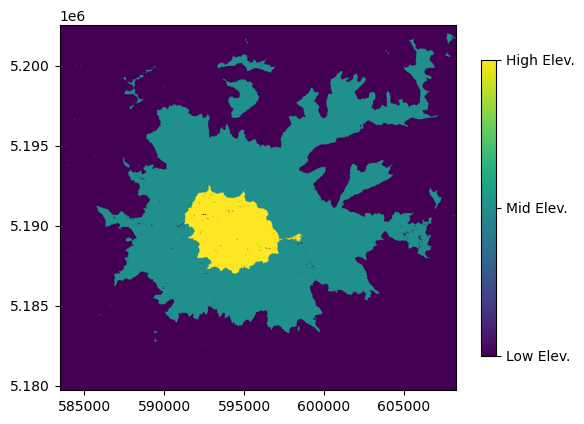

In [30]:
fig, ax = plt.subplots()

ct = show(array_classified, ax=ax, transform=dataset.transform)

im = ct.get_images()[0]
cbar = fig.colorbar(im, ticks=[1, 2, 3], shrink=0.8)
cbar.ax.set_yticklabels(['Low Elev. ', 'Mid Elev.', 'High Elev.']);

**Looks the same! But notice the new units on the colobar scale.**

Now let's save this raster to a new file.

## Writing Raster files

Writing a file with `rasterio` involves defining the characteristics of the output raster and then writing your data array to it.

The characteristics are provided in the form of metadata (or "profile") which takes the form of a dictionary containing parameters we looked at above, including:
- dimensions of the raster (height, width)
- data type (dtype)
- number of bands (count)
- coordinate reference system (crs), and;
- georeferencing transform (transform)

### A word on transforms

In a raster dataset, an affine transformation is a mathematical mapping that relates the dataset's internal pixel coordinates to a real-world coordinate system. This process, known as georeferencing, allows software to correctly display, scale, and align the image with other spatial data. 


### The affine matrix 
A raster georeferencing transform can be expressed in mathematical terms using an affine matrix. This matrix defines a set of equations to convert a pixel's row and column coordinates into real-world x-y coordinates.

Geospatial coordinate reference systems are typically defined on a cartesian plane with the 0,0 origin in the bottom left. Raster data uses a different referencing system. Rows and columns with the 0,0 origin in the upper left and rows increase and you move down while the columns increase as you go right.

![title](data/rasterio/xyrowcol.png)

Image from https://www.perrygeo.com/python-affine-transforms.html. More info on the Python [Affine](https://affine.readthedocs.io/en/latest/) library. 

In [31]:
with rasterio.open(data_path / '20150818_rainier_summer-tile-30.tif') as dataset:
    transform = dataset.transform
    meta = dataset.meta

transform

Affine(30.0, 0.0, 583464.253406,
       0.0, -30.0, 5202549.0989)

### There are six elements in the affine transform (a, b, c, d, e, f)

- a = width of a pixel
- b = row rotation (typically zero)
- c = x-coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)
- f = y-coordinate of the of the upper-left corner of the upper-left pixel


rasterio provides an `rasterio.Affine` class, which can be used to create and manipulate new transforms

In [32]:
transform = rasterio.Affine(
    a=30.0, 
    b=0.0, 
    c=583464.253406,
    d=0.0, 
    e=-30.0, 
    f=5202549.0989
)

transform

Affine(30.0, 0.0, 583464.253406,
       0.0, -30.0, 5202549.0989)

### ... now back to writing that raster

In [33]:
new_raster_file = data_path / '20150818_rainier_summer-tile-30_feet.tif'

The long way - specify metadata and close manually:

In [34]:
out_dataset = rasterio.open(
    new_raster_file, 
    mode='w',         # open file in write mode this time
    driver='GTiff',
    width=827,
    height=761,
    count=1,
    crs=32610,
    transform=transform,
    dtype='float32',
    nodata=0.0
)
    
out_dataset.write(array_ft, 1)
out_dataset.close()

The short way - use `with` and  the original file metadata, `meta`, using `**` to unpack the dictionary into arguments

In [35]:
with rasterio.open(new_raster_file, 'w', **meta) as out_dataset:
    out_dataset.write(array_ft, 1)

## Building a raster from scratch

### Class activity

Create and write your own raster. This raster should be:
1) 10 rows, 10 columns
3) The raster can contain any value(s) you want, but bonus points for a checkerboard pattern
4) Set upper left coordinates to:
   - xul: 569005.45
   - yul: 10746521.08
5) EPSG is 3070

Use the completed code blocks above as a template. **Don't be ashamed to adapt code you got from someone else or on the internet to accomplish something useful.** 

## Masking (aka clipping) rasters using polygons

The rasterio `mask` function can be used to clip a raster to exclude areas outside of the polygon(s) defined in the shapefile. 

In [36]:
from rasterio.mask import mask

As an example, we can use the geometry information contained in the shapefile we plotted earlier as the mask

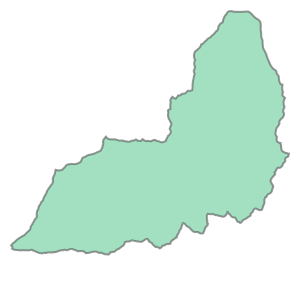

In [37]:
white_riv_huc12.loc[0,'geometry']

In [38]:
crop_shape = white_riv_huc12['geometry']

A quick refersher - here's what we're working with:

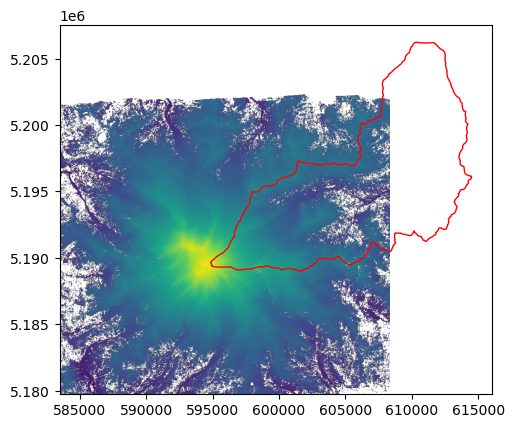

In [39]:
fig, ax = plt.subplots()
with rasterio.open(raster_file) as dataset:
    show(dataset, ax=ax, vmin=500, vmax=4500)
    white_riv_huc12.plot(ax=ax, edgecolor='red', facecolor='None');

Now let's use the `mask` function to clip the raster data with the polygon.

Set `crop=True` to crop the raster's extent to the bounding box of the polygon(s).

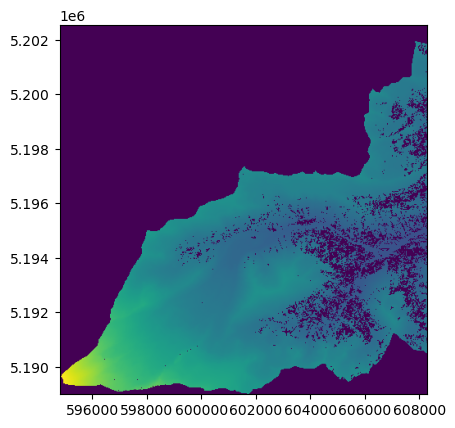

In [40]:
with rasterio.open(raster_file) as dataset:
    mask_image, mask_transform = mask(
        dataset, 
        crop_shape, 
        crop=True
    )
    mask_meta = dataset.meta

show(mask_image, transform=mask_transform);

In [41]:
mask_meta.update({"driver": "GTiff",
                 "height": mask_image.shape[1],
                 "width": mask_image.shape[2],
                 "transform": mask_transform})

masked_file = data_path / '20150818_rainier_summer-tile-30_masked.tif'

with rasterio.open(masked_file, "w", **mask_meta) as out_dataset:
    out_dataset.write(mask_image)